In [1]:
# Vaguely following this lesson plan:
# http://course.fast.ai/lessons/lesson4.html

%reload_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
import os.path
assert os.path.basename(os.getcwd()) == 'notebooks', os.path.basename(os.getcwd())
code_dir = os.path.join(os.getcwd(), os.pardir, 'code')
if code_dir not in sys.path:
    sys.path.append(code_dir)
    os.environ['PYTHONPATH'] = os.environ.get('PYTHONPATH', '') + os.pathsep + code_dir
model_dir = os.path.join(os.getcwd(), os.pardir, 'models')
    
# Keras warns about non-keras optimizers
import warnings
warnings.simplefilter("ignore", UserWarning)
import keras
%aimport keras_util

Using TensorFlow backend.


In [2]:
from keras.utils import get_file

ml20_origin = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
get_file('ml-20m.zip', ml20_origin, cache_dir='../data', cache_subdir='movielens', extract=True)
ml20_path = '../data/movielens/ml-20m/'
! echo && ls {ml20_path}


README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


In [3]:
import pandas as pd
ratings = pd.read_csv(ml20_path + 'ratings.csv')

In [4]:
# Convert movies to indices
import numpy as np

unique_users = ratings.userId.unique()
unique_movies = ratings.movieId.unique()
print('unique count', len(unique_users), len(unique_movies))
print('max id', unique_users.max(), unique_movies.max())
users_unique = pd.Series(np.arange(len(unique_users)), index=unique_users)
movies_unique = pd.Series(np.arange(len(unique_movies)), index=unique_movies)

ratings.userId = ratings.userId.map(users_unique)
ratings.movieId = ratings.movieId.map(movies_unique)
print('max normalized id', ratings.userId.max(), ratings.movieId.max())

n_users = len(users_unique)
n_movies = len(movies_unique)

from IPython.display import display
ratings.drop('timestamp', axis=1, inplace=True)
display(ratings.head())

unique count 138493 26744
max id 138493 131262
max normalized id 138492 26743


,userId,movieId,rating
0,0,0,3.5
1,0,1,3.5
2,0,2,3.5
3,0,3,3.5
4,0,4,3.5


In [5]:
movie_factors = 50
user_factors = n_users * movie_factors // n_movies

In [6]:
from keras.layers import * 
from keras.regularizers import l2
from keras.models import Model

def recommender_net():
    keras_util.seedall()

    user_in = Input(shape=(1,), dtype='int64', name='user_in')
    u = Embedding(n_users, user_factors, input_length=1)(user_in)
    movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
    m = Embedding(n_movies, movie_factors, input_length=1)(movie_in)
    u = Dense(50, activation='relu')(u)
    um = Dot(axes=2)([u, m])

    # Per-user and per-movie bias (to catch "generally good movies" and "generally nice raters")
    ub = Embedding(n_users, 1, input_length=1, name='user_bias')(user_in)
    mb = Embedding(n_movies, 1, input_length=1, name='movie_bias')(movie_in)

    biased = Add()([um, ub, mb])

    return Model([user_in, movie_in], Flatten()(biased))

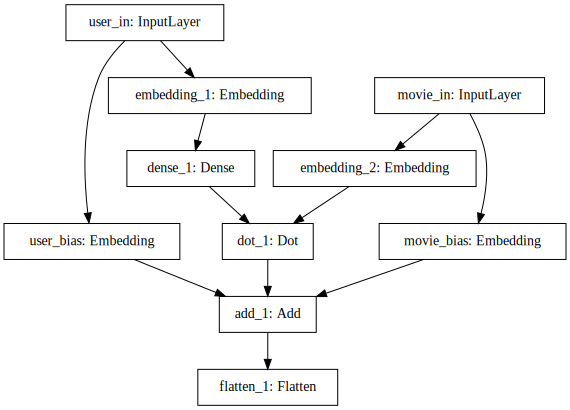

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot
import graphviz
import keras.backend as K

SVG(model_to_dot(recommender_net()).create(prog='dot', format='svg'))

In [8]:
from sklearn.model_selection import train_test_split
train_and_valid, test = train_test_split(ratings, test_size=0.3, random_state=1234)
train, valid = train_test_split(train_and_valid, test_size=0.3, random_state=5678)

In [9]:
from yellowfin import YFOptimizer
from keras import optimizers

opts = {
        'sgd+clip':
        lambda: optimizers.SGD(clipvalue=1),
        'sgd+momentum+clip':
        lambda: optimizers.SGD(momentum=0.9, nesterov=True, clipvalue=1),
        'adam+clip':
        lambda: optimizers.Adam(clipvalue=1),
        'nadam+clip':
        lambda: optimizers.Nadam(clipvalue=1),
        'adamax+clip':
        lambda: optimizers.Adamax(clipvalue=1),
        'yellowfin+clip':
        lambda: optimizers.TFOptimizer(YFOptimizer(clip_thresh=1))
    }

In [10]:
import ray
ray.init(num_gpus=keras_util.ngpu())

Waiting for redis server at 127.0.0.1:50613 to respond...
Waiting for redis server at 127.0.0.1:36004 to respond...
Starting local scheduler with 32 CPUs and 2 GPUs.
View the web UI at http://localhost:8888/notebooks/ray_ui96526.ipynb


{'local_scheduler_socket_names': ['/tmp/scheduler62881971'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store2232187', manager_name='/tmp/plasma_manager20742557', manager_port=51622)],
 'redis_address': '127.0.0.1:50613'}

In [11]:
import keras
import contextlib

model_dir = os.path.join(os.getcwd(), os.pardir, 'models', 'movielens')

def _train_recommender(optname):
    if os.path.isfile('history'):
        print('already trained')
        return keras_util.load_object('history')

    with keras_util.rectime('constructing network {:.0f} sec'):
        keras_util.seedall()
        net = recommender_net()
        net.compile(loss='mse', optimizer=opts[optname]())

    tb = keras.callbacks.TensorBoard(log_dir='.')
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='net', monitor='val_loss', save_best_only=True)
    earlystop = keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=0)            

    with keras_util.rectime('training {:.0f} sec'):
        hist = net.fit(
            [train.userId, train.movieId],
            train.rating,
            epochs=100,
            batch_size=500000,
            verbose=0,
            callbacks=[checkpoint, tb, earlystop],
            validation_data=([valid.userId, valid.movieId], valid.rating))
    keras_util.save_object(hist.history, 'history')
    return hist.history

@ray.remote(num_gpus=1, max_calls=1)
def train_recommender(optname):
    with keras_util.ray_gpu_session():
        with keras_util.cd(os.path.join(model_dir, optname)):
            with open('stdout', 'w') as f:
                with contextlib.redirect_stdout(f):
                    return _train_recommender(optname)

hists = ray.get([train_recommender.remote(optname) for optname in opts.keys()])

In [16]:
hist_dict = {n: r for n, r in zip(opts.keys(), hists)}

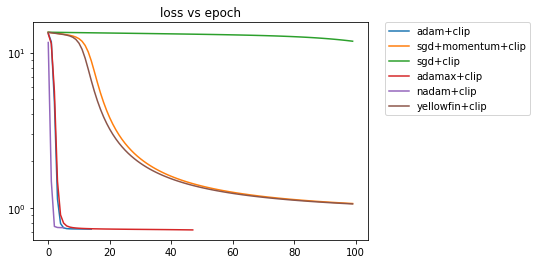

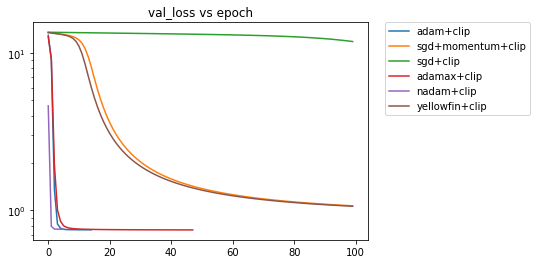

In [17]:
for losstype in ['loss', 'val_loss']:
    for optname, hist in hist_dict.items():
        plt.semilogy(hist[losstype], label=optname)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.)
    plt.title(losstype + ' vs epoch')
    plt.show()

In [18]:
from tabulate import tabulate
best_val = [{'optimizer': optname, 'val_loss': min(hist['val_loss'])} for optname, hist in hist_dict.items()]
best_val.sort(key=lambda d: d['val_loss'])
print(tabulate(best_val, tablefmt='grid', floatfmt="6.4f"))

+-------------------+---------+
| adamax+clip       |  0.7525 |
+-------------------+---------+
| adam+clip         |  0.7538 |
+-------------------+---------+
| nadam+clip        |  0.7603 |
+-------------------+---------+
| yellowfin+clip    |  1.0636 |
+-------------------+---------+
| sgd+momentum+clip |  1.0700 |
+-------------------+---------+
| sgd+clip          | 11.8087 |
+-------------------+---------+


In [32]:
K.clear_session()
keras_util.seedall()
chosen_opt = 'adamax+clip'

with keras_util.rectime('loading ' + chosen_opt + ' {:.0f} sec'):
    old_net = os.path.join(model_dir, optname, 'net')
    final_net = os.path.join(model_dir, 'final-net')
    net = recommender_net()
    net.compile(loss='mse', optimizer=opts[chosen_opt]())
    net.load_weights(old_net)
    
with keras_util.rectime('evaluating on train {:.0f} sec'):
    train_mse = net.evaluate([train.userId, train.movieId], train.rating, batch_size=500000)

print('training until loss <= {:0.4f}'.format(train_mse))
with keras_util.rectime('post-train {:.0f} sec'):
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=final_net, monitor='loss', save_best_only=True)
    early_stopping = keras_util.EarlyStopLambda(
        metric='loss', should_stop=lambda loss: loss <= train_mse)   

    net.fit(
        [train_and_valid.userId, train_and_valid.movieId],
        train_and_valid.rating,
        epochs=100,
        batch_size=500000,
        callbacks=[checkpoint, early_stopping])

final_eval = net.evaluate([test.userId, test.movieId], test.rating, batch_size=500000)
print()
print('final test mse', final_eval)

loading adamax+clip 0 sec
9800128/9800128 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s     
evaluating on train 5 sec
training until loss <= 1.0574
Epoch 1/100
14000184/14000184 [==============================] - ETA: 44s - loss: 1.05 - ETA: 27s - loss: 1.05 - ETA: 21s - loss: 1.04 - ETA: 18s - loss: 1.04 - ETA: 16s - loss: 1.03 - ETA: 14s - loss: 1.03 - ETA: 13s - loss: 1.02 - ETA: 12s - loss: 1.02 - ETA: 11s - loss: 1.01 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 1.0046 - ETA: 8s - loss: 0.999 - ETA: 8s - loss: 0.994 - ETA: 7s - loss: 0.990 - ETA: 7s - loss: 0.985 - ETA: 6s - loss: 0.981 - ETA: 5s - loss: 0.976 - ETA: 5s - loss: 0.972 - ETA: 4s - loss: 0.968 - ETA: 4s - loss: 0.964 - ETA: 3s - loss: 0.960 - ETA: 3s - loss: 0.956 - ETA: 2s - loss: 0.952 - ETA: 2s - loss: 0.949 - ETA: 1s - loss: 0.945 - ETA: 1s - loss: 0.941 - ETA: 0s - loss: 0